In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis/Dataset (S/validation/labels/0566.png
/kaggle/input/thesis/Dataset (S/validation/labels/0133.png
/kaggle/input/thesis/Dataset (S/validation/labels/0006.png
/kaggle/input/thesis/Dataset (S/validation/labels/0516.png
/kaggle/input/thesis/Dataset (S/validation/labels/0003.png
/kaggle/input/thesis/Dataset (S/validation/labels/0217.png
/kaggle/input/thesis/Dataset (S/validation/labels/0816.png
/kaggle/input/thesis/Dataset (S/validation/labels/0337.png
/kaggle/input/thesis/Dataset (S/validation/labels/0835.png
/kaggle/input/thesis/Dataset (S/validation/labels/0096.png
/kaggle/input/thesis/Dataset (S/validation/labels/0451.png
/kaggle/input/thesis/Dataset (S/validation/labels/0301.png
/kaggle/input/thesis/Dataset (S/validation/labels/0947.png
/kaggle/input/thesis/Dataset (S/validation/labels/0405.png
/kaggle/input/thesis/Dataset (S/validation/labels/0341.png
/kaggle/input/thesis/Dataset (S/validation/labels/0208.png
/kaggle/input/thesis/Dataset (S/validation/labels/0369.p

# ✅ Cell 1: Import thư viện cần thiết

In [2]:
!pip install -q segmentation-models-pytorch albumentations timm

import os
import cv2
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


# Cell 2: Định nghĩa cấu hình chung + đọc danh sách (image, mask) cho train/val (no augmentation)

In [3]:
# thay thế
# Cell 2: Cấu hình + tự động xác định DATA_DIR và thư mục masks linh hoạt (no augmentation)

class CFG:
    IMG_SIZE = 512
    EPOCHS = 80
    BATCH_SIZE = 4
    LR = 1e-4
    NUM_WORKERS = 2
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# 1) Tìm thư mục gốc có cấu trúc .../train/images
ROOT_SEARCH = "/kaggle/input/thesis"

candidate_roots = []
for root, dirs, files in os.walk(ROOT_SEARCH):
    norm_root = root.replace("\\", "/")
    if norm_root.endswith("/train/images"):
        dataset_root = norm_root.rsplit("/train/images", 1)[0]
        candidate_roots.append(dataset_root)

candidate_roots = sorted(set(candidate_roots))
print("Candidate DATA_DIR found:", candidate_roots)

if len(candidate_roots) == 0:
    raise FileNotFoundError(
        "Không tìm thấy thư mục train/images trong /kaggle/input/thesis. Kiểm tra lại cấu trúc dataset."
    )

DATA_DIR = candidate_roots[0]
print("Using DATA_DIR:", DATA_DIR)

# 2) Hàm tìm thư mục mask phù hợp (mask / masks / labels / segmentation...)
def find_mask_dir(split: str):
    split_dir = os.path.join(DATA_DIR, split)
    if not os.path.exists(split_dir):
        raise FileNotFoundError(f"Không tồn tại thư mục split: {split_dir}")
    
    # Ưu tiên thư mục tên chứa 'mask' hoặc 'label'
    candidates = []
    for name in os.listdir(split_dir):
        path = os.path.join(split_dir, name)
        if os.path.isdir(path):
            low = name.lower()
            if "mask" in low or "label" in low or "seg" in low:
                candidates.append(path)
    
    # Nếu không tìm thấy, fallback về 'masks'
    if not candidates:
        default_dir = os.path.join(split_dir, "masks")
        if os.path.isdir(default_dir):
            candidates.append(default_dir)
    
    if not candidates:
        print(f"[WARN] Không tìm thấy thư mục mask/label trong: {split_dir}")
        return None
    
    # Chọn candidate đầu tiên
    mask_dir = sorted(candidates)[0]
    print(f"{split} mask_dir:", mask_dir)
    return mask_dir

def get_image_mask_pairs(split: str):
    image_dir = os.path.join(DATA_DIR, split, "images")
    if not os.path.isdir(image_dir):
        print(f"[WARN] Không tìm thấy {image_dir}")
        return []
    
    mask_dir = find_mask_dir(split)
    if mask_dir is None:
        return []
    
    image_paths = sorted(glob(os.path.join(image_dir, "*")))
    exts = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]
    pairs = []

    for img_path in image_paths:
        base = os.path.splitext(os.path.basename(img_path))[0]
        found_mask = None
        for ext in exts:
            cand = os.path.join(mask_dir, base + ext)
            if os.path.exists(cand):
                found_mask = cand
                break
        if found_mask is not None:
            pairs.append((img_path, found_mask))

    print(f"{split} - found {len(pairs)} pairs")
    # In thử 3 cặp đầu để kiểm tra
    for p in pairs[:3]:
        print(" sample:", p[0], "->", p[1])
    return pairs

train_pairs = get_image_mask_pairs("train")
validation_pairs = get_image_mask_pairs("validation")

print("Total train:", len(train_pairs), "| Total val:", len(validation_pairs))


Candidate DATA_DIR found: ['/kaggle/input/thesis/Dataset (S']
Using DATA_DIR: /kaggle/input/thesis/Dataset (S
train mask_dir: /kaggle/input/thesis/Dataset (S/train/labels
train - found 810 pairs
 sample: /kaggle/input/thesis/Dataset (S/train/images/0011.png -> /kaggle/input/thesis/Dataset (S/train/labels/0011.png
 sample: /kaggle/input/thesis/Dataset (S/train/images/0012.png -> /kaggle/input/thesis/Dataset (S/train/labels/0012.png
 sample: /kaggle/input/thesis/Dataset (S/train/images/0013.png -> /kaggle/input/thesis/Dataset (S/train/labels/0013.png
validation mask_dir: /kaggle/input/thesis/Dataset (S/validation/labels
validation - found 200 pairs
 sample: /kaggle/input/thesis/Dataset (S/validation/images/0001.png -> /kaggle/input/thesis/Dataset (S/validation/labels/0001.png
 sample: /kaggle/input/thesis/Dataset (S/validation/images/0002.png -> /kaggle/input/thesis/Dataset (S/validation/labels/0002.png
 sample: /kaggle/input/thesis/Dataset (S/validation/images/0003.png -> /kaggle/input/

# Cell 3: Định nghĩa Dataset + DataLoader với transforms cơ bản (no augmentation)

In [4]:
class DFUSegDataset(Dataset):
    def __init__(self, pairs, img_size=CFG.IMG_SIZE):
        self.pairs = pairs
        self.img_size = img_size
        self.transform = A.Compose([
            A.Resize(self.img_size, self.img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # chuẩn về nhị phân 0/1
        mask = (mask > 0).astype("float32")

        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"].unsqueeze(0)  # (1, H, W)

        return image, mask

# dùng train_pairs và val_pairs đã tạo ở Cell 2
train_dataset = DFUSegDataset(train_pairs, img_size=CFG.IMG_SIZE)
val_dataset = DFUSegDataset(validation_pairs, img_size=CFG.IMG_SIZE)

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.BATCH_SIZE,
    shuffle=True,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG.BATCH_SIZE,
    shuffle=False,
    num_workers=CFG.NUM_WORKERS,
    pin_memory=True,
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))


Train batches: 203 | Val batches: 50


# Cell 4: Định nghĩa hàm loss BCE + Dice và các metric cơ bản (Dice, IoU, Precision, Recall)

In [5]:
def dice_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2.0 * inter + smooth) / (union + smooth)
    return dice.mean().item()

def iou_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(2, 3))
    union = (pred + target - pred * target).sum(dim=(2, 3))
    iou = (inter + smooth) / (union + smooth)
    return iou.mean().item()

def bce_dice_loss(pred, target, smooth=1e-5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sig = torch.sigmoid(pred)
    inter = (pred_sig * target).sum(dim=(2, 3))
    union = pred_sig.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = 1 - ((2 * inter + smooth) / (union + smooth))
    return bce + dice.mean()

print("✅ Defined: dice_coef, iou_coef, and bce_dice_loss")


✅ Defined: dice_coef, iou_coef, and bce_dice_loss


# Cell 5: Định nghĩa hàm train và validation cho 1 epoch (no augmentation)

In [6]:
import gc

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_dice, total_iou = 0.0, 0.0, 0.0

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(CFG.DEVICE), masks.to(CFG.DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = bce_dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(outputs, masks)
        total_iou += iou_coef(outputs, masks)

    mean_loss = total_loss / len(loader)
    mean_dice = total_dice / len(loader)
    mean_iou = total_iou / len(loader)

    return mean_loss, mean_dice, mean_iou


@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval()
    total_loss, total_dice, total_iou = 0.0, 0.0, 0.0

    for images, masks in tqdm(loader, desc="Validation", leave=False):
        images, masks = images.to(CFG.DEVICE), masks.to(CFG.DEVICE)

        outputs = model(images)
        loss = bce_dice_loss(outputs, masks)

        total_loss += loss.item()
        total_dice += dice_coef(outputs, masks)
        total_iou += iou_coef(outputs, masks)

    mean_loss = total_loss / len(loader)
    mean_dice = total_dice / len(loader)
    mean_iou = total_iou / len(loader)

    return mean_loss, mean_dice, mean_iou


def train_model(model, model_name, num_epochs=CFG.EPOCHS):
    model = model.to(CFG.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, verbose=True
    )

    best_dice = 0.0
    best_loss = np.inf

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": [],
        "train_iou": [],
        "val_iou": [],
    }

    save_path = f"{model_name}_best_no_aug.pth"

    for epoch in range(1, num_epochs + 1):
        print(f"\n===== {model_name} | Epoch {epoch}/{num_epochs} =====")

        torch.cuda.empty_cache()
        gc.collect()

        train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_dice, val_iou = valid_one_epoch(model, val_loader)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)

        print(
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f} | "
            f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}"
        )

        if val_dice > best_dice:
            best_dice = val_dice
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model: {save_path} (Val Dice: {best_dice:.4f})")

    print(f"\nBest Val Dice for {model_name}: {best_dice:.4f} (Loss: {best_loss:.4f})")
    return model, history

# Cell 6: Định nghĩa hàm train_model()

In [7]:
def train_model(model, model_name, num_epochs=CFG.EPOCHS):
    model = model.to(CFG.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, verbose=True
    )

    best_dice = 0.0
    best_loss = np.inf

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": [],
        "train_iou": [],
        "val_iou": [],
    }

    save_path = f"{model_name}_best_no_aug.pth"

    for epoch in range(1, num_epochs + 1):
        print(f"\n===== {model_name} | Epoch {epoch}/{num_epochs} =====")

        torch.cuda.empty_cache()
        gc.collect()

        # nhận đủ 3 giá trị
        train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_dice, val_iou = valid_one_epoch(model, val_loader)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)

        print(
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f} | "
            f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}"
        )

        if val_dice > best_dice:
            best_dice = val_dice
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model: {save_path} (Val Dice: {best_dice:.4f})")

    print(f"\nBest Val Dice for {model_name}: {best_dice:.4f} (Loss: {best_loss:.4f})")
    return model, history

# Cell 9: Huấn luyện DeepLabV3+ (no augmentation) + plot train/val Loss, Dice, IoU

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



===== DeepLabV3Plus_NoAug | Epoch 1/80 =====


Train Loss: 1.0392 | Val Loss: 0.7630 | Train Dice: 0.5157 | Val Dice: 0.6741 | Train IoU: 0.3960 | Val IoU: 0.5516
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.6741)

===== DeepLabV3Plus_NoAug | Epoch 2/80 =====


Train Loss: 0.6467 | Val Loss: 0.5246 | Train Dice: 0.7171 | Val Dice: 0.7711 | Train IoU: 0.5963 | Val IoU: 0.6666
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.7711)

===== DeepLabV3Plus_NoAug | Epoch 3/80 =====


Train Loss: 0.3956 | Val Loss: 0.3210 | Train Dice: 0.7886 | Val Dice: 0.7970 | Train IoU: 0.6833 | Val IoU: 0.6959
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.7970)

===== DeepLabV3Plus_NoAug | Epoch 4/80 =====


Train Loss: 0.2671 | Val Loss: 0.2723 | Train Dice: 0.8294 | Val Dice: 0.7978 | Train IoU: 0.7335 | Val IoU: 0.7015
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.7978)

===== DeepLabV3Plus_NoAug | Epoch 5/80 =====


Train Loss: 0.2050 | Val Loss: 0.2207 | Train Dice: 0.8546 | Val Dice: 0.8223 | Train IoU: 0.7687 | Val IoU: 0.7342
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8223)

===== DeepLabV3Plus_NoAug | Epoch 6/80 =====


Train Loss: 0.1823 | Val Loss: 0.2569 | Train Dice: 0.8634 | Val Dice: 0.7839 | Train IoU: 0.7832 | Val IoU: 0.6927

===== DeepLabV3Plus_NoAug | Epoch 7/80 =====


Train Loss: 0.1828 | Val Loss: 0.1955 | Train Dice: 0.8574 | Val Dice: 0.8270 | Train IoU: 0.7738 | Val IoU: 0.7432
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8270)

===== DeepLabV3Plus_NoAug | Epoch 8/80 =====


Train Loss: 0.1507 | Val Loss: 0.1909 | Train Dice: 0.8801 | Val Dice: 0.8368 | Train IoU: 0.8060 | Val IoU: 0.7545
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8368)

===== DeepLabV3Plus_NoAug | Epoch 9/80 =====


Train Loss: 0.1365 | Val Loss: 0.1859 | Train Dice: 0.8920 | Val Dice: 0.8365 | Train IoU: 0.8242 | Val IoU: 0.7563

===== DeepLabV3Plus_NoAug | Epoch 10/80 =====


Train Loss: 0.1263 | Val Loss: 0.1868 | Train Dice: 0.8980 | Val Dice: 0.8361 | Train IoU: 0.8331 | Val IoU: 0.7542

===== DeepLabV3Plus_NoAug | Epoch 11/80 =====


Train Loss: 0.1224 | Val Loss: 0.2002 | Train Dice: 0.9045 | Val Dice: 0.8248 | Train IoU: 0.8406 | Val IoU: 0.7407

===== DeepLabV3Plus_NoAug | Epoch 12/80 =====


Train Loss: 0.1210 | Val Loss: 0.1892 | Train Dice: 0.9044 | Val Dice: 0.8348 | Train IoU: 0.8411 | Val IoU: 0.7554

===== DeepLabV3Plus_NoAug | Epoch 13/80 =====


Train Loss: 0.1132 | Val Loss: 0.1873 | Train Dice: 0.9136 | Val Dice: 0.8352 | Train IoU: 0.8539 | Val IoU: 0.7552

===== DeepLabV3Plus_NoAug | Epoch 14/80 =====


Train Loss: 0.1093 | Val Loss: 0.1878 | Train Dice: 0.9151 | Val Dice: 0.8413 | Train IoU: 0.8573 | Val IoU: 0.7606
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8413)

===== DeepLabV3Plus_NoAug | Epoch 15/80 =====


Train Loss: 0.1127 | Val Loss: 0.1804 | Train Dice: 0.9062 | Val Dice: 0.8431 | Train IoU: 0.8468 | Val IoU: 0.7634
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8431)

===== DeepLabV3Plus_NoAug | Epoch 16/80 =====


Train Loss: 0.1056 | Val Loss: 0.1766 | Train Dice: 0.9131 | Val Dice: 0.8449 | Train IoU: 0.8565 | Val IoU: 0.7668
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8449)

===== DeepLabV3Plus_NoAug | Epoch 17/80 =====


Train Loss: 0.0995 | Val Loss: 0.1763 | Train Dice: 0.9184 | Val Dice: 0.8452 | Train IoU: 0.8647 | Val IoU: 0.7672
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8452)

===== DeepLabV3Plus_NoAug | Epoch 18/80 =====


Train Loss: 0.0982 | Val Loss: 0.1809 | Train Dice: 0.9203 | Val Dice: 0.8474 | Train IoU: 0.8671 | Val IoU: 0.7696
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8474)

===== DeepLabV3Plus_NoAug | Epoch 19/80 =====


Train Loss: 0.0959 | Val Loss: 0.1778 | Train Dice: 0.9224 | Val Dice: 0.8444 | Train IoU: 0.8703 | Val IoU: 0.7657

===== DeepLabV3Plus_NoAug | Epoch 20/80 =====


Train Loss: 0.1458 | Val Loss: 0.2307 | Train Dice: 0.8799 | Val Dice: 0.7963 | Train IoU: 0.8120 | Val IoU: 0.6996

===== DeepLabV3Plus_NoAug | Epoch 21/80 =====


Train Loss: 0.1137 | Val Loss: 0.1939 | Train Dice: 0.9110 | Val Dice: 0.8314 | Train IoU: 0.8489 | Val IoU: 0.7505

===== DeepLabV3Plus_NoAug | Epoch 22/80 =====


Train Loss: 0.1118 | Val Loss: 0.2157 | Train Dice: 0.9067 | Val Dice: 0.8108 | Train IoU: 0.8475 | Val IoU: 0.7252

===== DeepLabV3Plus_NoAug | Epoch 23/80 =====


Train Loss: 0.1035 | Val Loss: 0.1835 | Train Dice: 0.9210 | Val Dice: 0.8387 | Train IoU: 0.8643 | Val IoU: 0.7582

===== DeepLabV3Plus_NoAug | Epoch 24/80 =====


Train Loss: 0.0924 | Val Loss: 0.1764 | Train Dice: 0.9267 | Val Dice: 0.8449 | Train IoU: 0.8766 | Val IoU: 0.7672

===== DeepLabV3Plus_NoAug | Epoch 25/80 =====


Train Loss: 0.0873 | Val Loss: 0.1732 | Train Dice: 0.9325 | Val Dice: 0.8479 | Train IoU: 0.8853 | Val IoU: 0.7721
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8479)

===== DeepLabV3Plus_NoAug | Epoch 26/80 =====


Train Loss: 0.0840 | Val Loss: 0.1737 | Train Dice: 0.9339 | Val Dice: 0.8473 | Train IoU: 0.8887 | Val IoU: 0.7711

===== DeepLabV3Plus_NoAug | Epoch 27/80 =====


Train Loss: 0.0826 | Val Loss: 0.1721 | Train Dice: 0.9388 | Val Dice: 0.8491 | Train IoU: 0.8945 | Val IoU: 0.7738
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8491)

===== DeepLabV3Plus_NoAug | Epoch 28/80 =====


Train Loss: 0.0817 | Val Loss: 0.1740 | Train Dice: 0.9385 | Val Dice: 0.8485 | Train IoU: 0.8949 | Val IoU: 0.7730

===== DeepLabV3Plus_NoAug | Epoch 29/80 =====


Train Loss: 0.0798 | Val Loss: 0.1722 | Train Dice: 0.9413 | Val Dice: 0.8492 | Train IoU: 0.8988 | Val IoU: 0.7736
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8492)

===== DeepLabV3Plus_NoAug | Epoch 30/80 =====


Train Loss: 0.0787 | Val Loss: 0.1722 | Train Dice: 0.9397 | Val Dice: 0.8492 | Train IoU: 0.8980 | Val IoU: 0.7735

===== DeepLabV3Plus_NoAug | Epoch 31/80 =====


Train Loss: 0.0789 | Val Loss: 0.1717 | Train Dice: 0.9381 | Val Dice: 0.8493 | Train IoU: 0.8962 | Val IoU: 0.7737
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8493)

===== DeepLabV3Plus_NoAug | Epoch 32/80 =====


Train Loss: 0.0788 | Val Loss: 0.1738 | Train Dice: 0.9442 | Val Dice: 0.8487 | Train IoU: 0.9032 | Val IoU: 0.7736

===== DeepLabV3Plus_NoAug | Epoch 33/80 =====


Train Loss: 0.0777 | Val Loss: 0.1735 | Train Dice: 0.9416 | Val Dice: 0.8485 | Train IoU: 0.9004 | Val IoU: 0.7725

===== DeepLabV3Plus_NoAug | Epoch 34/80 =====


Train Loss: 0.0763 | Val Loss: 0.1702 | Train Dice: 0.9428 | Val Dice: 0.8511 | Train IoU: 0.9025 | Val IoU: 0.7762
✅ Saved best model: DeepLabV3Plus_NoAug_best_no_aug.pth (Val Dice: 0.8511)

===== DeepLabV3Plus_NoAug | Epoch 35/80 =====


Train Loss: 0.0757 | Val Loss: 0.1737 | Train Dice: 0.9420 | Val Dice: 0.8483 | Train IoU: 0.9022 | Val IoU: 0.7727

===== DeepLabV3Plus_NoAug | Epoch 36/80 =====


Train Loss: 0.0750 | Val Loss: 0.1715 | Train Dice: 0.9450 | Val Dice: 0.8499 | Train IoU: 0.9055 | Val IoU: 0.7751

===== DeepLabV3Plus_NoAug | Epoch 37/80 =====


Train Loss: 0.0742 | Val Loss: 0.1725 | Train Dice: 0.9469 | Val Dice: 0.8489 | Train IoU: 0.9079 | Val IoU: 0.7731

===== DeepLabV3Plus_NoAug | Epoch 38/80 =====


Train Loss: 0.0744 | Val Loss: 0.1725 | Train Dice: 0.9429 | Val Dice: 0.8494 | Train IoU: 0.9038 | Val IoU: 0.7738

===== DeepLabV3Plus_NoAug | Epoch 39/80 =====


Train Loss: 0.0733 | Val Loss: 0.1744 | Train Dice: 0.9453 | Val Dice: 0.8484 | Train IoU: 0.9069 | Val IoU: 0.7726

===== DeepLabV3Plus_NoAug | Epoch 40/80 =====


Train Loss: 0.0727 | Val Loss: 0.1741 | Train Dice: 0.9494 | Val Dice: 0.8482 | Train IoU: 0.9112 | Val IoU: 0.7722

===== DeepLabV3Plus_NoAug | Epoch 41/80 =====


Train Loss: 0.0709 | Val Loss: 0.1748 | Train Dice: 0.9500 | Val Dice: 0.8471 | Train IoU: 0.9132 | Val IoU: 0.7714

===== DeepLabV3Plus_NoAug | Epoch 42/80 =====


Train Loss: 0.0683 | Val Loss: 0.1751 | Train Dice: 0.9525 | Val Dice: 0.8482 | Train IoU: 0.9176 | Val IoU: 0.7729

===== DeepLabV3Plus_NoAug | Epoch 43/80 =====


Train Loss: 0.0677 | Val Loss: 0.1740 | Train Dice: 0.9540 | Val Dice: 0.8491 | Train IoU: 0.9194 | Val IoU: 0.7736

===== DeepLabV3Plus_NoAug | Epoch 44/80 =====


Train Loss: 0.0671 | Val Loss: 0.1734 | Train Dice: 0.9546 | Val Dice: 0.8491 | Train IoU: 0.9206 | Val IoU: 0.7740

===== DeepLabV3Plus_NoAug | Epoch 45/80 =====


Train Loss: 0.0672 | Val Loss: 0.1735 | Train Dice: 0.9546 | Val Dice: 0.8487 | Train IoU: 0.9206 | Val IoU: 0.7732

===== DeepLabV3Plus_NoAug | Epoch 46/80 =====


Train Loss: 0.0668 | Val Loss: 0.1746 | Train Dice: 0.9561 | Val Dice: 0.8480 | Train IoU: 0.9222 | Val IoU: 0.7729

===== DeepLabV3Plus_NoAug | Epoch 47/80 =====


Train Loss: 0.0656 | Val Loss: 0.1746 | Train Dice: 0.9572 | Val Dice: 0.8474 | Train IoU: 0.9242 | Val IoU: 0.7722

===== DeepLabV3Plus_NoAug | Epoch 48/80 =====


Train Loss: 0.0645 | Val Loss: 0.1736 | Train Dice: 0.9558 | Val Dice: 0.8495 | Train IoU: 0.9236 | Val IoU: 0.7745

===== DeepLabV3Plus_NoAug | Epoch 49/80 =====


Train Loss: 0.0643 | Val Loss: 0.1747 | Train Dice: 0.9582 | Val Dice: 0.8483 | Train IoU: 0.9261 | Val IoU: 0.7733

===== DeepLabV3Plus_NoAug | Epoch 50/80 =====


Train Loss: 0.0641 | Val Loss: 0.1743 | Train Dice: 0.9587 | Val Dice: 0.8482 | Train IoU: 0.9269 | Val IoU: 0.7731

===== DeepLabV3Plus_NoAug | Epoch 51/80 =====


Train Loss: 0.0638 | Val Loss: 0.1755 | Train Dice: 0.9600 | Val Dice: 0.8425 | Train IoU: 0.9283 | Val IoU: 0.7673

===== DeepLabV3Plus_NoAug | Epoch 52/80 =====


Train Loss: 0.0634 | Val Loss: 0.1742 | Train Dice: 0.9592 | Val Dice: 0.8486 | Train IoU: 0.9278 | Val IoU: 0.7732

===== DeepLabV3Plus_NoAug | Epoch 53/80 =====


Train Loss: 0.0630 | Val Loss: 0.1741 | Train Dice: 0.9584 | Val Dice: 0.8488 | Train IoU: 0.9273 | Val IoU: 0.7737

===== DeepLabV3Plus_NoAug | Epoch 54/80 =====


Train Loss: 0.0626 | Val Loss: 0.1748 | Train Dice: 0.9612 | Val Dice: 0.8474 | Train IoU: 0.9304 | Val IoU: 0.7720

===== DeepLabV3Plus_NoAug | Epoch 55/80 =====


Train Loss: 0.0636 | Val Loss: 0.1748 | Train Dice: 0.9590 | Val Dice: 0.8484 | Train IoU: 0.9284 | Val IoU: 0.7733

===== DeepLabV3Plus_NoAug | Epoch 56/80 =====


Train Loss: 0.0624 | Val Loss: 0.1742 | Train Dice: 0.9602 | Val Dice: 0.8483 | Train IoU: 0.9296 | Val IoU: 0.7730

===== DeepLabV3Plus_NoAug | Epoch 57/80 =====


Train Loss: 0.0620 | Val Loss: 0.1751 | Train Dice: 0.9619 | Val Dice: 0.8479 | Train IoU: 0.9316 | Val IoU: 0.7726

===== DeepLabV3Plus_NoAug | Epoch 58/80 =====


Train Loss: 0.0620 | Val Loss: 0.1754 | Train Dice: 0.9631 | Val Dice: 0.8478 | Train IoU: 0.9329 | Val IoU: 0.7726

===== DeepLabV3Plus_NoAug | Epoch 59/80 =====


Train Loss: 0.0620 | Val Loss: 0.1745 | Train Dice: 0.9607 | Val Dice: 0.8483 | Train IoU: 0.9305 | Val IoU: 0.7725

===== DeepLabV3Plus_NoAug | Epoch 60/80 =====


Train Loss: 0.0615 | Val Loss: 0.1750 | Train Dice: 0.9611 | Val Dice: 0.8486 | Train IoU: 0.9312 | Val IoU: 0.7733

===== DeepLabV3Plus_NoAug | Epoch 61/80 =====


Train Loss: 0.0612 | Val Loss: 0.1755 | Train Dice: 0.9615 | Val Dice: 0.8482 | Train IoU: 0.9319 | Val IoU: 0.7728

===== DeepLabV3Plus_NoAug | Epoch 62/80 =====


Train Loss: 0.0612 | Val Loss: 0.1743 | Train Dice: 0.9615 | Val Dice: 0.8484 | Train IoU: 0.9319 | Val IoU: 0.7732

===== DeepLabV3Plus_NoAug | Epoch 63/80 =====


Train Loss: 0.0612 | Val Loss: 0.1752 | Train Dice: 0.9614 | Val Dice: 0.8483 | Train IoU: 0.9318 | Val IoU: 0.7733

===== DeepLabV3Plus_NoAug | Epoch 64/80 =====


Train Loss: 0.0612 | Val Loss: 0.1757 | Train Dice: 0.9626 | Val Dice: 0.8478 | Train IoU: 0.9330 | Val IoU: 0.7729

===== DeepLabV3Plus_NoAug | Epoch 65/80 =====


Train Loss: 0.0610 | Val Loss: 0.1752 | Train Dice: 0.9628 | Val Dice: 0.8485 | Train IoU: 0.9333 | Val IoU: 0.7732

===== DeepLabV3Plus_NoAug | Epoch 66/80 =====


Train Loss: 0.0609 | Val Loss: 0.1761 | Train Dice: 0.9617 | Val Dice: 0.8471 | Train IoU: 0.9324 | Val IoU: 0.7717

===== DeepLabV3Plus_NoAug | Epoch 67/80 =====


Train Loss: 0.0609 | Val Loss: 0.1746 | Train Dice: 0.9628 | Val Dice: 0.8482 | Train IoU: 0.9332 | Val IoU: 0.7731

===== DeepLabV3Plus_NoAug | Epoch 68/80 =====


Train Loss: 0.0608 | Val Loss: 0.1744 | Train Dice: 0.9629 | Val Dice: 0.8492 | Train IoU: 0.9336 | Val IoU: 0.7736

===== DeepLabV3Plus_NoAug | Epoch 69/80 =====


Train Loss: 0.0608 | Val Loss: 0.1760 | Train Dice: 0.9642 | Val Dice: 0.8470 | Train IoU: 0.9348 | Val IoU: 0.7718

===== DeepLabV3Plus_NoAug | Epoch 70/80 =====


Train Loss: 0.0606 | Val Loss: 0.1769 | Train Dice: 0.9619 | Val Dice: 0.8468 | Train IoU: 0.9326 | Val IoU: 0.7715

===== DeepLabV3Plus_NoAug | Epoch 71/80 =====


Train Loss: 0.0608 | Val Loss: 0.1757 | Train Dice: 0.9629 | Val Dice: 0.8479 | Train IoU: 0.9336 | Val IoU: 0.7728

===== DeepLabV3Plus_NoAug | Epoch 72/80 =====


Train Loss: 0.0605 | Val Loss: 0.1762 | Train Dice: 0.9621 | Val Dice: 0.8471 | Train IoU: 0.9331 | Val IoU: 0.7718

===== DeepLabV3Plus_NoAug | Epoch 73/80 =====


Train Loss: 0.0606 | Val Loss: 0.1768 | Train Dice: 0.9632 | Val Dice: 0.8471 | Train IoU: 0.9340 | Val IoU: 0.7718

===== DeepLabV3Plus_NoAug | Epoch 74/80 =====


Train Loss: 0.0605 | Val Loss: 0.1758 | Train Dice: 0.9633 | Val Dice: 0.8471 | Train IoU: 0.9342 | Val IoU: 0.7718

===== DeepLabV3Plus_NoAug | Epoch 75/80 =====


Train Loss: 0.0605 | Val Loss: 0.1751 | Train Dice: 0.9620 | Val Dice: 0.8483 | Train IoU: 0.9329 | Val IoU: 0.7730

===== DeepLabV3Plus_NoAug | Epoch 76/80 =====


Train Loss: 0.0604 | Val Loss: 0.1764 | Train Dice: 0.9634 | Val Dice: 0.8474 | Train IoU: 0.9343 | Val IoU: 0.7720

===== DeepLabV3Plus_NoAug | Epoch 77/80 =====


Train Loss: 0.0605 | Val Loss: 0.1764 | Train Dice: 0.9645 | Val Dice: 0.8469 | Train IoU: 0.9354 | Val IoU: 0.7716

===== DeepLabV3Plus_NoAug | Epoch 78/80 =====


Train Loss: 0.0606 | Val Loss: 0.1757 | Train Dice: 0.9631 | Val Dice: 0.8481 | Train IoU: 0.9338 | Val IoU: 0.7729

===== DeepLabV3Plus_NoAug | Epoch 79/80 =====


Train Loss: 0.0604 | Val Loss: 0.1757 | Train Dice: 0.9634 | Val Dice: 0.8478 | Train IoU: 0.9344 | Val IoU: 0.7726

===== DeepLabV3Plus_NoAug | Epoch 80/80 =====


Train Loss: 0.0606 | Val Loss: 0.1772 | Train Dice: 0.9632 | Val Dice: 0.8464 | Train IoU: 0.9340 | Val IoU: 0.7709

Best Val Dice for DeepLabV3Plus_NoAug: 0.8511 (Loss: 0.1702)


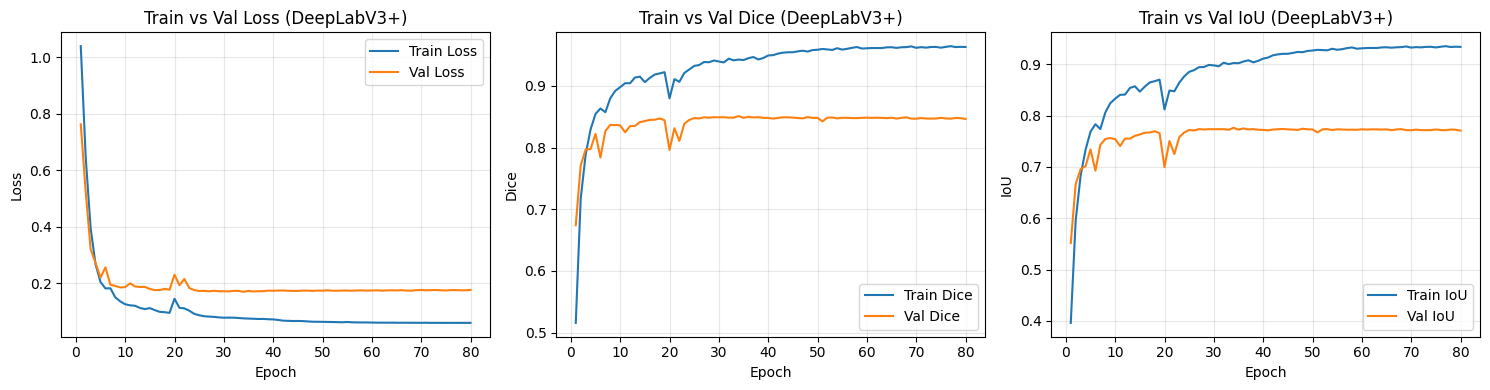

In [8]:
import gc
import matplotlib.pyplot as plt

# Cấu hình an toàn GPU
CFG.BATCH_SIZE = 2  # nếu vẫn OOM mới giảm xuống 1
torch.cuda.empty_cache()
gc.collect()

# Khởi tạo DeepLabV3+ với encoder ResNet50 (chuẩn benchmark)
model_deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

# Huấn luyện
model_deeplab, hist_deeplab = train_model(model_deeplab, model_name="DeepLabV3Plus_NoAug")

# Vẽ biểu đồ
epochs = range(1, len(hist_deeplab["train_loss"]) + 1)

plt.figure(figsize=(15,4))

# (1) Loss
plt.subplot(1,3,1)
plt.plot(epochs, hist_deeplab["train_loss"], label="Train Loss")
plt.plot(epochs, hist_deeplab["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss (DeepLabV3+)")
plt.legend()
plt.grid(alpha=0.3)

# (2) Dice
plt.subplot(1,3,2)
plt.plot(epochs, hist_deeplab["train_dice"], label="Train Dice")
plt.plot(epochs, hist_deeplab["val_dice"], label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Train vs Val Dice (DeepLabV3+)")
plt.legend()
plt.grid(alpha=0.3)

# (3) IoU
plt.subplot(1,3,3)
plt.plot(epochs, hist_deeplab["train_iou"], label="Train IoU")
plt.plot(epochs, hist_deeplab["val_iou"], label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Train vs Val IoU (DeepLabV3+)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()